In [3]:
# import zipfile
# with zipfile.ZipFile("train.zip","r") as zip_ref:
#     zip_ref.extractall("data/train")

In [4]:
# import zipfile
# with zipfile.ZipFile("test.zip","r") as zip_ref:
#     zip_ref.extractall("data/test")

In [2]:
!pip3 install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = 'data/train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set
print(len(trainImg))

4750/4750


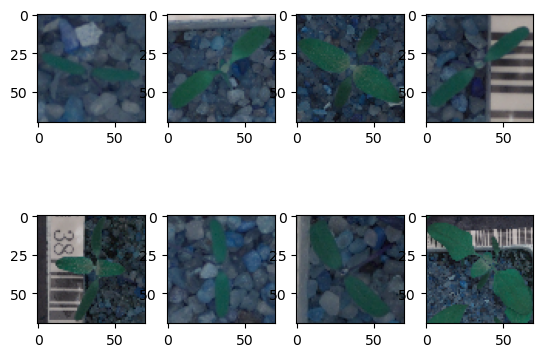

In [3]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

In [4]:
# clearTrainImg = []
# examples = []; getEx = True
# for img in trainImg:
#     # Use gaussian blur
#     blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
#     # Convert to HSV image
#     hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
#     # Create mask (parameters - green color range)
#     lower_green = (25, 40, 50)
#     upper_green = (75, 255, 255)
#     mask = cv2.inRange(hsvImg, lower_green, upper_green)  
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
#     # Create bool mask
#     bMask = mask > 0  
    
#     # Apply the mask
#     clear = np.zeros_like(img, np.uint8)  # Create empty image
#     clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
#     clearTrainImg.append(clear)  # Append image without backgroung
    
#     # Show examples
#     if getEx:
#         plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
#         plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
#         plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
#         plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
#         plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
#         plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
#         getEx = False

# clearTrainImg = np.asarray(clearTrainImg)



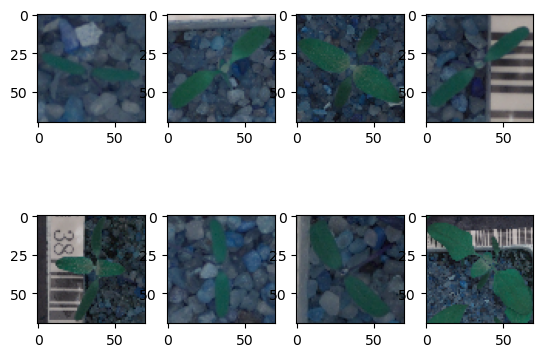

In [5]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

In [6]:
clearTrainImg = trainImg
clearTrainImg = clearTrainImg / 255

2024-04-26 17:15:18.202165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 17:15:18.202240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 17:15:18.202936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 17:15:18.211702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


<Axes: xlabel='0'>

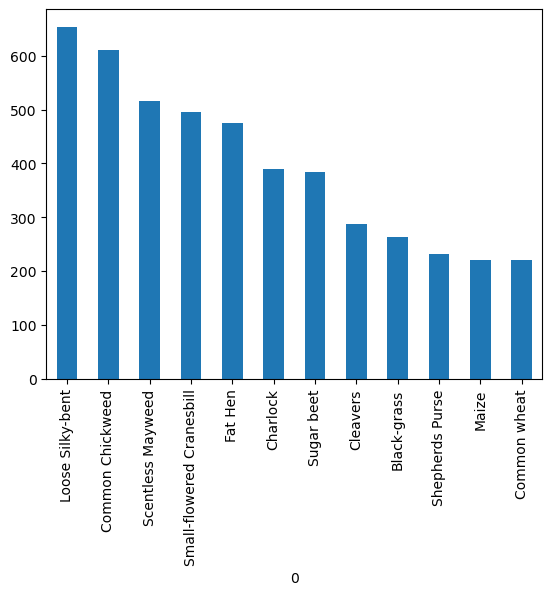

In [7]:
from keras.utils import to_categorical
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

In [8]:
from sklearn.model_selection import train_test_split

# trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
#                                                 test_size=0.1, random_state=seed, 
#                                                 stratify = clearTrainLabel)

trainX, tempX, trainY, tempY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.4, random_state=seed, 
                                                stratify = clearTrainLabel)
valX,testX,valY,testY = train_test_split(tempX,tempY,test_size = 0.2,random_state=seed,stratify=tempY)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

In [10]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-04-26 17:15:29.322835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 848 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-04-26 17:15:29.332909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78667 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-04-26 17:15:29.338514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78667 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization (Batch  (None, 66, 66, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 31, 31, 64)        256       
 chNormalization)                                                
                                                        

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="model/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="model/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# fit model
hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64),
                           epochs=50, validation_data=(valX, valY), 
                           steps_per_epoch=trainX.shape[0]//64, callbacks=callbacks_list)


/scratch/local/30128284/ipykernel_1728431/3114251321.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64),


Epoch 1/50


2024-04-26 17:15:59.900649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-26 17:16:00.647662: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-04-26 17:16:01.422494: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 17:16:01.422851: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were availa

21/44 [=============>................] - ETA: 2s - loss: 3.3601 - accuracy: 0.1510

2024-04-26 17:16:16.641683: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 812.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 17:16:16.654837: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 812.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


44/44 [==============================] - ETA: 0s - loss: 2.9528 - accuracy: 0.2114
Epoch 1: val_accuracy improved from -inf to 0.13684, saving model to model/weights.best_01-0.14.hdf5


/apps/tensorflow/2.15/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to model/weights.last_auto4.hdf5
44/44 [==============================] - 28s 234ms/step - loss: 2.9528 - accuracy: 0.2114 - val_loss: 6.0684 - val_accuracy: 0.1368 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 2.2218 - accuracy: 0.3586
Epoch 2: val_accuracy improved from 0.13684 to 0.13816, saving model to model/weights.best_02-0.14.hdf5

Epoch 2: saving model to model/weights.last_auto4.hdf5
44/44 [==============================] - 6s 135ms/step - loss: 2.2218 - accuracy: 0.3586 - val_loss: 13.0124 - val_accuracy: 0.1382 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.4684
Epoch 3: val_accuracy did not improve from 0.13816

Epoch 3: saving model to model/weights.last_auto4.hdf5
44/44 [==============================] - 3s 74ms/step - loss: 1.7539 - accuracy: 0.4684 - val_loss: 9.6245 - val_accuracy: 0.1382 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - ETA:

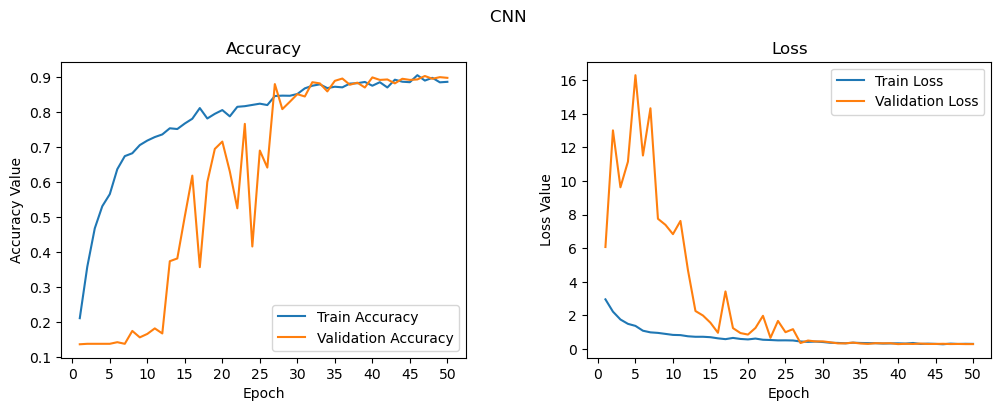

In [14]:

def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
printHistory(hist,"CNN ",50)

In [13]:
model.load_weights("./model/weights.best_45-0.90.hdf5")

# data = np.load("../input/plantrecomodels/Data.npz")
# d = dict(zip(("trainX","testX","trainY", "testY"), (data[k] for k in data)))
# trainX = d['trainX']
# testX = d['testX']
# trainY = d['trainY']
# testY = d['testY']

# print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.metrics_names)
print(model.evaluate(testX, testY))  # Evaluate on test set

['loss', 'accuracy']
12/12 [==============================] - 1s 50ms/step - loss: 0.2932 - accuracy: 0.8842
[0.29321131110191345, 0.8842105269432068]


In [17]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have a trained CNN model named 'model'
# And you have a set of test data X_test and true labels y_true

# Make predictions
y_pred_prob = model.predict(testX)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# If y_true is one-hot encoded, convert it to class labels
y_true_classes = np.argmax(testY, axis=1) # Assuming y_true is one-hot encoded

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='macro') # or 'micro', 'weighted', etc. based on your requirement

print("F1 Score:", f1)


12/12 [==============================] - 0s 3ms/step
F1 Score: 0.8750733784927788


In [23]:
print("=========== transfer learning =======")

=========== transfer learning =======


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output
import gc
tf.config.run_functions_eagerly(True)
pretrained = xception.Xception(input_shape=[240,240, 3], include_top=False)
pretrained.trainable = True
model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dense(12,activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
model.load_weights("./model/weights.best_02-0.91.hdf5")

2024-04-26 21:13:42.853038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 21:13:42.853108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 21:13:42.853710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 21:13:42.859269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 21:13:52.219374: I tenso

Loading Black-grass
Loading Charlock
Loading Cleavers
Loading Common Chickweed
Loading Common wheat
Loading Fat Hen
Loading Loose Silky-bent
Loading Maize
Loading Scentless Mayweed
Loading Shepherds Purse
Loading Small-flowered Cranesbill
Loading Sugar beet
935385
Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


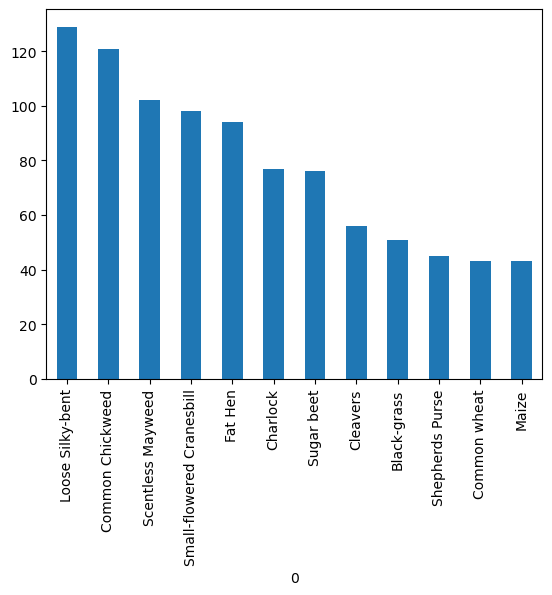

In [4]:

import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

ScaleTo = 240  # px to scale
seed = 7  # fixing random
trainImg = []
trainLabel = []

# Obtain images and resizing, obtain labels
for folder in ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]:
    path = 'data/train/'+folder+'/*.png' 
    print("Loading " + folder)
    files = glob(path)
    j = 1
    num = len(files)
    for img in files:
        if j== int(num*0.2):
            break
        print(str(j) + "/" + str(num), end="\r")
        trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
        trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
        j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set
print(len(trainImg))

clearTrainImg = trainImg
clearTrainImg = clearTrainImg / 255

from keras.utils import to_categorical
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

from sklearn.model_selection import train_test_split

# trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
#                                                 test_size=0.1, random_state=seed, 
#                                                 stratify = clearTrainLabel)

trainX, tempX, trainY, tempY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.4, random_state=seed, 
                                                stratify = clearTrainLabel)
valX,testX,valY,testY = train_test_split(tempX,tempY,test_size = 0.2,random_state=seed,stratify=tempY)

# print(model.evaluate(trainX, trainY))  # Evaluate on train set
# print(model.metrics_names)
print(model.predict(testX))  # Evaluate on test set